<p align="center">
    <img src="https://drive.google.com/uc?id=1DvKhAzLtk-Hilu7Le73WAOz2EBR5d41G" width="400"/>
</p>

---

<p align="center">
<img src="https://pytorch.org/assets/images/pytorch-logo.png" alt="drawing" width="100"/>
</p>



<h1 style="text-align: center;"> Introduction to Pytorch for Deep Learning</h1>



In this introduction to PyTorch for deep learning, we will dive into certain packages and utilities of the library made to facilitate data handling and training opertations. We will explore similar concepts that were seen in the previous lectures, but in a different way. We will specifically focus on the functions of ``Dataset`` and ``Dataloader`` objects and their roles, also exploring adjacent functionlities for data splitting, pre-processing, and analysis. We will also discuss the basic training workflow and how ``PyTorch`` integrates these different steps. We must consider that ``PyTorch`` is an extensive library, and these lectures are designed to introduce you to its main concepts, particularly the ones that are useful for the completion of this module. With the links and references below, we encourage you to further explore the library as you see fit.


#### **Morning contents/agenda**
1. Basic functionalities: Tensor Handling like Numpy Arrays

2. Data Handling with ``Torchvision``

3. Batch Handling with ``Dataloader``

4. Review of the ``Pytorch`` training workflow for a classification task

5. Customisation of ``Dataset`` classes


#### **Afternoon contents/agenda**

1. Understanding the basics:
- [But what is a convolution?](https://www.youtube.com/watch?v=KuXjwB4LzSA&ab_channel=3Blue1Brown)

- [But what is a neural network?](https://www.youtube.com/watch?v=aircAruvnKk&t=1s&ab_channel=3Blue1Brown)

- [What is backpropagation really doing?](https://www.youtube.com/watch?v=Ilg3gGewQ5U&t=2s&ab_channel=3Blue1Brown)

2. Exercise 2

#### **Learning Outcomes**

1. Get acquainted with common ``Torchvision`` datasets and integrate them into a ``Pytorch`` workflow

2. Learn the basic usage of ``torchvision.transforms``

3. Understand the difference between a ``Dataset`` and a ``Dataloader`` and how to integrate them

4. Understand the ``Pytorch`` workflow for training a classification model

5. Learn to create custom ``Dataset`` classes

7. Learn to access the ``Pytorch`` documentation

<br/>

---

<br/>

In [15]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
except:
  pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
!pip install torch-summary progressbar2 -q

import torch
import torch.nn as nn
import numpy as np
import random

import matplotlib.pyplot as plt

def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True


def set_device(device="cpu", idx=0):
    if device != "cpu":
        if torch.cuda.device_count() > idx and torch.cuda.is_available():
            print("Cuda installed! Running on GPU {} {}!".format(idx, torch.cuda.get_device_name(idx)))
            device="cuda:{}".format(idx)
        elif torch.cuda.device_count() > 0 and torch.cuda.is_available():
            print("Cuda installed but only {} GPU(s) available! Running on GPU 0 {}!".format(torch.cuda.device_count(), torch.cuda.get_device_name()))
            device="cuda:0"
        else:
            device="cpu"
            print("No GPU available! Running on CPU")
    return device

device = set_device("cuda")

Cuda installed! Running on GPU 0 Tesla T4!


## Basic functionalities: Tensor Handling like Numpy Arrays

In [18]:
my_data = [i for i in range(100)]
my_tensor = torch.tensor(my_data)
my_tensor, my_tensor.shape

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
         54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
         72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
         90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 torch.Size([100]))

In [19]:
# 调整维度, 在第一个维度上再加一个维度。
my_tensor = my_tensor.unsqueeze(0)
my_tensor, my_tensor.shape

(tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
          36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
          54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
          72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
          90, 91, 92, 93, 94, 95, 96, 97, 98, 99]]),
 torch.Size([1, 100]))

In [20]:
my_reshaped_tensor = my_tensor.view(1, 2, 50)
my_reshaped_tensor, my_reshaped_tensor.shape

(tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
           17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
           34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
          [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
           67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
           84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]]]),
 torch.Size([1, 2, 50]))

In [21]:
# 从标准正态分布（均值 = 0，标准差 = 1）中随机抽取的张量。
rand_tensor = torch.randn((3,256,256))
rand_tensor, rand_tensor.mean(), rand_tensor.std(), rand_tensor.max(), rand_tensor.sum()

(tensor([[[-0.9624,  0.6416,  0.8834,  ..., -0.4439,  2.1859,  0.7214],
          [ 0.9477, -1.0253,  0.5227,  ..., -1.1752,  1.0711, -1.0754],
          [ 0.9955,  1.0970,  1.5464,  ...,  1.0448,  0.0710,  0.4380],
          ...,
          [ 0.6534, -1.5943,  1.2324,  ..., -1.5378,  0.4838,  1.0662],
          [-1.6741,  1.1736,  0.4924,  ..., -0.7997, -1.0503,  0.7131],
          [-0.6168,  0.7590,  1.4957,  ..., -1.3436, -1.1311,  0.8380]],
 
         [[ 0.3372, -0.0652, -0.2884,  ...,  0.6366,  0.1249, -0.2274],
          [ 0.5511,  0.4897, -1.9034,  ...,  0.9611, -0.7982,  1.4631],
          [ 0.7841, -1.6158, -0.0864,  ...,  1.7846,  0.4317,  0.2060],
          ...,
          [-0.2066,  1.7441,  0.5093,  ..., -1.4492,  0.4703,  0.4074],
          [-1.2512, -1.5614,  0.6291,  ...,  1.8425, -1.4510,  0.9976],
          [ 0.5398, -0.3198, -0.2881,  ...,  0.0980, -0.3891,  1.8108]],
 
         [[ 0.0932, -1.1195,  0.4485,  ..., -1.8393,  0.0144, -0.1802],
          [ 0.2139,  1.2094,

In [22]:
rand_tensor_sq = rand_tensor ** 2
print(rand_tensor_sq.shape)

torch.Size([3, 256, 256])


In [23]:
# 计算输入张量的逆
torch.linalg.inv(rand_tensor)

tensor([[[-2.0771e-01, -2.4739e-01,  5.8235e-01,  ..., -3.3052e-01,
          -1.5674e-01, -1.2993e-01],
         [-8.8059e-02, -1.6173e-01,  2.5746e-01,  ..., -1.5597e-01,
          -6.2432e-02, -5.4900e-02],
         [ 3.2147e-01,  1.9414e-01, -8.0878e-01,  ...,  4.8572e-01,
           1.8317e-01,  2.8252e-01],
         ...,
         [-5.5288e-02, -1.3137e-02,  1.8349e-01,  ..., -1.0681e-01,
          -2.9851e-02, -7.9503e-02],
         [-6.0334e-02, -8.4529e-02,  2.1228e-01,  ..., -9.6749e-02,
          -3.8173e-02, -6.8488e-03],
         [ 3.8214e-03,  3.6458e-02, -2.1376e-02,  ..., -5.8740e-03,
           8.9689e-03, -5.8211e-02]],

        [[ 6.6188e-01,  2.9692e-01, -7.0569e-02,  ..., -5.2607e-01,
          -1.6550e-01,  2.5040e-01],
         [-1.1365e-01, -1.0781e-01,  3.3567e-02,  ...,  3.5752e-02,
           8.9665e-03,  7.8556e-03],
         [ 1.0396e-01,  3.6294e-02, -3.1336e-02,  ..., -1.0839e-01,
          -2.0591e-02,  3.3846e-02],
         ...,
         [-3.1100e-01, -1

In [24]:
#对多维数据执行FFT
torch.fft.fftn(rand_tensor)

tensor([[[ -12.5103+0.0000e+00j,   18.3666-1.2654e+02j, -399.2390-6.7668e+01j,
           ..., -314.0876-1.0462e+02j, -399.2390+6.7668e+01j,
            18.3666+1.2654e+02j],
         [ -27.1410-1.8040e+01j,  -78.5616-3.3092e+02j, -271.1718-4.7123e+02j,
           ...,  268.3426+3.7777e+02j,  217.5663-7.7950e+00j,
          -306.3429-8.1805e+02j],
         [-266.3904-2.9127e+02j,  134.7559+3.5045e+01j, -216.9678-7.0568e+00j,
           ...,  438.0759-9.7877e+01j,  697.8260+9.2999e+01j,
          -131.8506+8.0301e+02j],
         ...,
         [-556.9109+5.3775e+02j, -148.9896+2.9728e+02j,  -85.5901-9.4862e+01j,
           ..., -509.5850+6.8577e+01j,  -12.6683-1.2635e+02j,
            -9.4064-4.1039e+02j],
         [-266.3904+2.9127e+02j, -131.8506-8.0301e+02j,  697.8261-9.2999e+01j,
           ...,  756.9384-1.6949e+02j, -216.9679+7.0568e+00j,
           134.7560-3.5045e+01j],
         [ -27.1410+1.8040e+01j, -306.3430+8.1805e+02j,  217.5663+7.7949e+00j,
           ..., -194.7928+6.1157

## Data Handling with Torchvision's KMNIST

[``Torchvision``](https://pytorch.org/vision/stable/index.html) is one of many support libraries for the ``Pytorch`` project. It provides a range of popular models (pre-trained or not) and datasets, as well as image transformations that are useful for computer vision problems. Because it is a support library, its integration to ``Pytorch`` is native and straigth-forward, as we will see below.

In [25]:
import torchvision

train_dataset = torchvision.datasets.KMNIST(root="./", train = True, download=True)
test_dataset = torchvision.datasets.KMNIST(root="./", train = True, download=True)

100%|██████████| 18165135/18165135 [00:09<00:00, 1848499.97it/s]


Extracting ./KMNIST/raw/train-images-idx3-ubyte.gz to ./KMNIST/raw



100%|██████████| 29497/29497 [00:00<00:00, 392566.78it/s]


Extracting ./KMNIST/raw/train-labels-idx1-ubyte.gz to ./KMNIST/raw



100%|██████████| 3041136/3041136 [00:01<00:00, 1651278.65it/s]


Extracting ./KMNIST/raw/t10k-images-idx3-ubyte.gz to ./KMNIST/raw



100%|██████████| 5120/5120 [00:00<00:00, 18970703.60it/s]

Extracting ./KMNIST/raw/t10k-labels-idx1-ubyte.gz to ./KMNIST/raw



In [26]:
print(type(train_dataset), "\n")
print(train_dataset, "\n")
print(dir(train_dataset), "\n") # Information held in the dataset object

<class 'torchvision.datasets.mnist.KMNIST'> 

Dataset KMNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train 

['__add__', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_check_exists', '_check_legacy_exist', '_format_transform_repr', '_is_protocol', '_load_data', '_load_legacy_data', '_repr_indent', 'class_to_idx', 'classes', 'data', 'download', 'extra_repr', 'mirrors', 'processed_folder', 'raw_folder', 'resources', 'root', 'target_transform', 'targets', 'test_data', 'test_file', 'test_labels', 'train', 'train_data', 'train_labels', 'training_file', 'transf

In [27]:
train_dataset

Dataset KMNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train

In [28]:
class_to_idx = list(train_dataset.class_to_idx)
print(class_to_idx)

['o', 'ki', 'su', 'tsu', 'na', 'ha', 'ma', 'ya', 're', 'wo']


* The method ``__getitem__`` is called when indexing samples within Pytorch Datasets

* For this dataset class, ``__getitem__`` returns two variables: the image and its target label

(<PIL.Image.Image image mode=L size=28x28 at 0x7AF6D86A7BB0>, 8) 



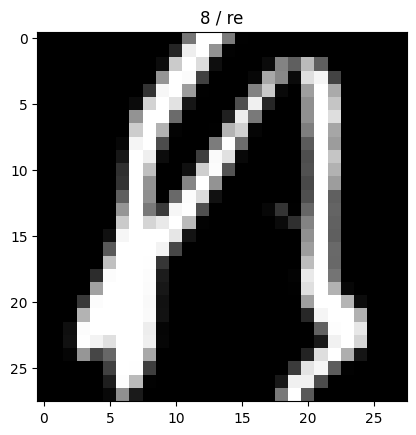

<class 'PIL.Image.Image'>


In [29]:
sample =  train_dataset[0]
print(sample, "\n")

plt.imshow(sample[0], "gray")
plt.title(str(sample[1]) + " / " + class_to_idx[sample[1]])
plt.show()
print(type(sample[0]))


#### Let's visualise a few samples

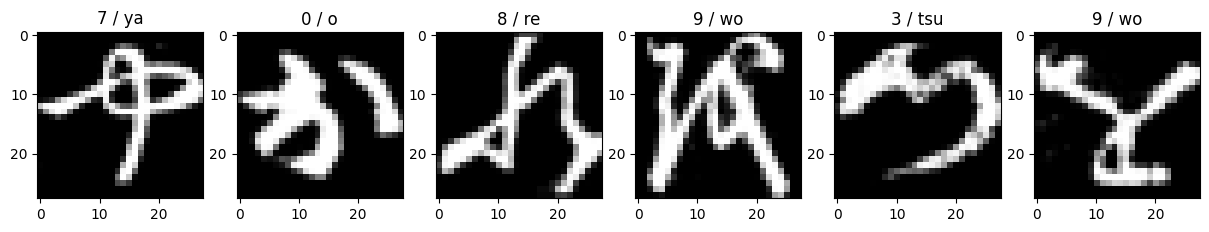

In [30]:
set_seed(42)
# 从0到 train_dataset 数据集大小减一的范围内随机选择6个整数
idxs = torch.randint(low=0, high=len(train_dataset), size=(6,))
fig, axs = plt.subplots(1, 6, figsize=(15, 5))
for i, idx in enumerate((idxs)):
    img, target = train_dataset[idx]
    axs[i].imshow(img, cmap = 'gray')
    axs[i].set_title(str(target) + " / " + class_to_idx[target])


* For convenience, let's change the format of the image from ``PIL`` to a ``torch.tensor`` object

* We will do so by using the ``torchvision.transforms`` module

* A list of transforms is often packaged into a ``Compose`` container

* Pytorch's standard practice is to apply such transformations inside the method ``__getitem__``

* It doesn't modify the data itself, but it will be applied whenever the dataset is indexed


* This circumvents the need of using pre-processing scripts to generate and store a processed dataset

In [31]:
from torchvision.transforms import Compose, ToTensor
transform = Compose([ToTensor(),]) # Compose a list of transformations

train_dataset = torchvision.datasets.KMNIST(root = "./", train = True, download = False, transform=transform, target_transform=None)
test_dataset = torchvision.datasets.KMNIST(root = "./", train = True, download = False, transform=transform, target_transform=None)

sample = train_dataset[0]
print(type(sample))
img, target = sample

print(img.shape, target)

<class 'tuple'>
torch.Size([1, 28, 28]) 8


* Using a ``ToTensor`` transformation is equivalent to calling ``TensorDataset``, as seen in the previous lecture. However, ``TensorDataset`` requires all data to be loaded into memory, which is not often feasible. Using the transformation allows the data to be transformed into ``torch.tensor`` objects as the data is accessed.

* Other transformations from the ``torch.transforms`` module can be found in its documentation [here](https://pytorch.org/vision/0.9/transforms.html)

* These include ``Normalize``, ``Pad``, ``RandomCrop``, ``Resize``, etc..

* There is even an option to create custom transforms with ``transforms.Lambda``. Let's have a look

In [32]:
from torchvision.transforms import Lambda

def add_noise(x, alpha=0.1):
    return x + alpha*torch.rand_like(x)


transform = Compose([ToTensor(),
                     Lambda(lambda x: add_noise(x, 0.5))
                     ])

train_dataset = torchvision.datasets.KMNIST(root = "./", train = True, download = False, transform=transform, target_transform=None)
test_dataset = torchvision.datasets.KMNIST(root = "./", train = True, download = False, transform=transform, target_transform=None)

print(train_dataset)

Dataset KMNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Lambda()
           )


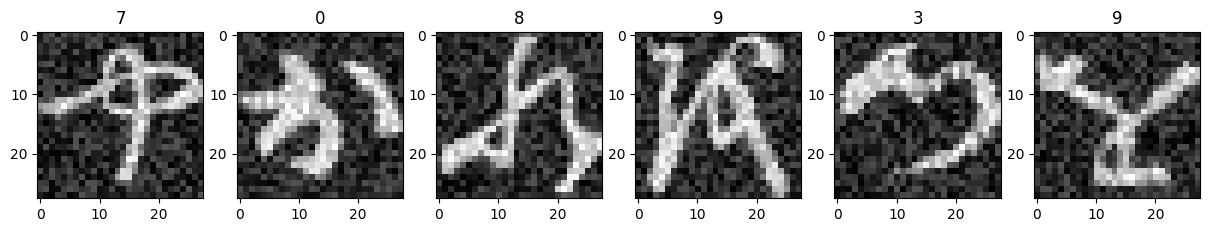

In [33]:
set_seed(42)
idxs = torch.randint(low=0, high=len(train_dataset), size=(6,))
fig, axs = plt.subplots(1, 6, figsize=(15, 5))
for i, idx in enumerate((idxs)):
    img, target = train_dataset[idx]
    axs[i].imshow(img[0], cmap="gray") # imshow expects W x H x C format
    axs[i].set_title(target)

* For now, all we need is the simple transformation of the dataset to ``torch.Tensor`` objects to allow ``PyTorch`` handling, and the standardisation of the data

In [34]:
print("min/max:", train_dataset.data.min().item(), "/", train_dataset.data.max().item())
print("mean: ", torch.mean(train_dataset.data / 255.).item())
print("std: ", torch.std(train_dataset.data / 255.).item())

min/max: 0 / 255
mean:  0.19176216423511505
std:  0.3483428359031677


In [35]:
from torchvision.transforms import Normalize

transform = Compose([ToTensor(), # In this transformation the data is scaled from [0, 1], see documentation
                     Normalize(0.19176216423511505, 0.3483428359031677), # This transforms applies a Z-score normalisation
                     ])

train_dataset = torchvision.datasets.KMNIST(root = "./", train=True, download=False, transform=transform, target_transform=None)
test_dataset = torchvision.datasets.KMNIST(root = "./", train=False, download=False, transform=transform, target_transform=None)

print(train_dataset)

Dataset KMNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.19176216423511505, std=0.3483428359031677)
           )


In [36]:
print("min/max:", train_dataset.data.min().item(), "/", train_dataset.data.max().item())
print("mean: ", torch.mean(train_dataset.data / 255.).item())
print("std: ", torch.std(train_dataset.data / 255.).item())
print("min/max:",  torch.mean(train_dataset.data /255.))

min/max: 0 / 255
mean:  0.19176216423511505
std:  0.3483428359031677
min/max: tensor(0.1918)


* Why is the data not standardised?

## Batch Handling with ``DataLoader``

* The process of training in Pytorch relies on batch management of a particular dataset

* This is done using the [``Dataloader``](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) module, which is responsible for accessing a [``Dataset``](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) derived object and handling it according to our needs

* In a way, the ``Dataloader`` and ``Dataset`` objects complement one another. The ``Dataset`` object handles **data** processing, whereas the ``Dataloader`` handles **batch** processing

In [37]:
batch_size = 32### # The batch size
num_workers = 0### # Subprocess for loading the data

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size = batch_size, num_workers=num_workers, shuffle=True)###

print(train_loader)
print(train_loader.__dict__) # Information held by the dataloader


{'dataset': Dataset KMNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.19176216423511505, std=0.3483428359031677)
           ), 'num_workers': 0, 'prefetch_factor': None, 'pin_memory': False, 'pin_memory_device': '', 'timeout': 0, 'worker_init_fn': None, '_DataLoader__multiprocessing_context': None, '_dataset_kind': 0, 'batch_size': 32, 'drop_last': False, 'sampler': <torch.utils.data.sampler.RandomSampler object at 0x7af6d4989090>, 'batch_sampler': <torch.utils.data.sampler.BatchSampler object at 0x7af6d4989b70>, 'generator': None, 'collate_fn': <function default_collate at 0x7af78ff10e50>, 'persistent_workers': False, '_DataLoader__initialized': True, '_IterableDataset_len_called': None, '_iterator': None}


#### "The ``DataLoader`` object combines a dataset and a sampler, and provides an iterable over the given dataset"

torch.Size([32, 1, 28, 28]) torch.Size([32])


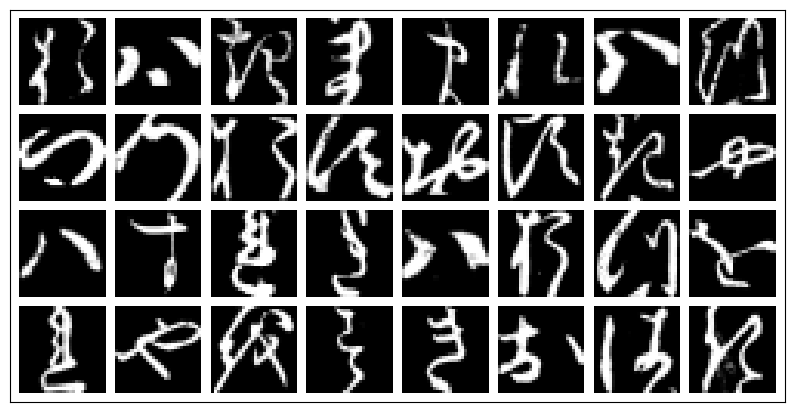

tensor([0, 5, 1, 6, 6, 8, 5, 3, 3, 3, 0, 2, 0, 2, 1, 7, 5, 2, 8, 1, 5, 0, 3, 9,
        8, 7, 9, 2, 1, 0, 5, 1])


In [38]:
set_seed(42)
train_batch_sample, train_batch_targets = next(iter(train_loader)) # syntax for directly iterating over the data loader
print(train_batch_sample.shape, train_batch_targets.shape)

# Visualise batch
from torchvision.utils import make_grid

batch_grid = make_grid(train_batch_sample, nrow=8, padding=3, pad_value=train_batch_sample.max())
plt.figure(figsize=(10,10))
plt.imshow(batch_grid[0], cmap="gray") # index because make_grid transforms grayscale images to RGB
plt.xticks([])
plt.yticks([])
plt.show()

print(train_batch_targets)

* Fetching the next batch of the ``train_loader`` iterator returns 32 samples and 32 corresponding target labels


In [39]:
print("min/max:", train_batch_sample.data.min().item() , "/" , train_dataset.data.max().item())
print("mean: ", torch.mean(train_batch_sample.data).item())
print("std: ", torch.std(train_batch_sample.data).item())

min/max: -0.550498366355896 / 255
mean:  -0.03642040491104126
std:  0.9737403392791748


## Training workflow: ``Dataset`` and  ``Dataloader`` in Perspective

* Let's begin by splitting our training dataset into training and validation using ``StratifiedShuffleSplit`` and ``Subset``

In [40]:
from sklearn.model_selection import StratifiedShuffleSplit
shuffler = StratifiedShuffleSplit(n_splits=10, test_size= 0.1, random_state= 42).split(train_dataset.data, train_dataset.targets)
train_idxs, valid_idxs = [(train_idx, valid_idx) for train_idx, valid_idx in shuffler][0]
print([(train_idx, valid_idx) for train_idx, valid_idx in shuffler])
# Split data with Subset (does not require data to be loaded into memory, it limits the range of which __getitem__ can be called)
from torch.utils.data import Subset
valid_dataset = Subset(train_dataset, valid_idxs)
train_dataset = Subset(train_dataset, train_idxs)

# Confirm split ratio and no overlapping idxs
print("train ratio:", len(train_dataset)/(len(train_dataset) + len(valid_dataset)))
print("valid ratio:", len(valid_dataset)/(len(train_dataset) + len(valid_dataset)))
print("no overlapping values", len(set(train_dataset) & set(valid_dataset)))

[]
train ratio: 0.9
valid ratio: 0.1
no overlapping values 0


In [41]:
print(type(train_dataset))
print(train_dataset.__dict__)

<class 'torch.utils.data.dataset.Subset'>
{'dataset': Dataset KMNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.19176216423511505, std=0.3483428359031677)
           ), 'indices': array([36195, 15295, 40977, ..., 39017, 53114, 55341])}


* ``Subset`` is one of the many useful tools created by Pytorch to manipulate a ``Dataset`` object without creating copies. Other operations include concatenation and chaining, and can be found in the documentation [here](https://pytorch.org/docs/stable/data.html)

* We now need two dataloaders

In [42]:
batch_size = 64 # The batch size
num_workers = 0 # Subprocess for loading the data

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size = batch_size, num_workers=num_workers, shuffle=True)###

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size = 1000, num_workers=num_workers, shuffle=False)###

#### Let's now return to the simple feed-forward network from the previous lecture, with some custom modifications


In [43]:
class simpleFFN(nn.Module):
    def __init__(self, input_size, hidden_size_1=100, hidden_size_2=50, output_size=10):
        super(simpleFFN, self).__init__()
        self.hidden_1 = nn.Linear(input_size, hidden_size_1, bias=False)
        self.hidden_2 = nn.Linear(hidden_size_1, hidden_size_2, bias=False)
        self.output = nn.Linear(hidden_size_2, 10, bias=False)
        self.activation = nn.Sigmoid()
    def forward(self, X):
    # X_flattened = X.flatten(start_dim=1)
    # print("X_flattened:", X_flattened.shape)
    # 展成二维，从第二个开始展，
        z1 = self.hidden_1(X.flatten(start_dim=1))
        #print("z1:", z1.shape)

        a1 = self.activation(z1)
        #print("a1:", a1.shape)

        z2 = self.hidden_2(a1)
        #print("z2:", z2.shape)

        a2 = self.activation(z2)
        #print("a2:", a2.shape)

        z3 = self.output(a2)
#        print("z3:", z3.shape)

        a3 = self.activation(z3)
  #      print("a3:", a3.shape)

        return a3



In [44]:
# 创建模型实例，假设输入大小为 784（例如 28x28 的图像展平后的大小）
model = simpleFFN(input_size=28*28)

# 创建一个符合输入要求的假数据
# 假设批量大小为 1
input_tensor = torch.randn(1, 784)

# 通过模型传递输入以打印每层的形状
output = model(input_tensor)

In [45]:
set_seed(42)
model = simpleFFN(1*28*28, 200, 50, 10).to(device)
print(model)
# Check number of parameters
nparam_layer1 = ((1*28*28) * (200))
nparam_layer2 = (200 * 50)
nparam_layer3 = (50 * 10)
print(nparam_layer1 + nparam_layer2 + nparam_layer3)

simpleFFN(
  (hidden_1): Linear(in_features=784, out_features=200, bias=False)
  (hidden_2): Linear(in_features=200, out_features=50, bias=False)
  (output): Linear(in_features=50, out_features=10, bias=False)
  (activation): Sigmoid()
)
167300


* More conveniently:

In [46]:
sum([p.numel() for p in model.parameters()])  #.parameters() is a method inherited from the nn.Module base class

167300

* Even more conveniently:

In [47]:
from torchsummary import summary
summ = summary(model, torch.Size((1,28,28)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 200]                 156,800
├─Sigmoid: 1-2                           [-1, 200]                 --
├─Linear: 1-3                            [-1, 50]                  10,000
├─Sigmoid: 1-4                           [-1, 50]                  --
├─Linear: 1-5                            [-1, 10]                  500
├─Sigmoid: 1-6                           [-1, 10]                  --
Total params: 167,300
Trainable params: 167,300
Non-trainable params: 0
Total mult-adds (M): 0.17
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.64
Estimated Total Size (MB): 0.64


In [48]:
# Test model input and output sizes with batch sample
x = next(iter(train_loader))[0].to(device)
y = model(x)
print(x.shape, y.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64, 10])


### The Training Workflow: Forward, Loss, Backpropagate, Optimise, Repeat

* Now that we have our data loaders ready to be iterated, let's revisit the training workflow from the last lecture

* The general steps for training a model are:
    1. Peform a foward pass of the **batch** throught the model to get initial outputs

    2. Compare the outputs with the desired targets using a difference ``metric`` to obtain a ``loss`` measure

    3. Compute derivatives of all model weights and biases with respect to the loss using back propagation
    
    4. Take an optimisation step and repeat for next batch


* Once the network goes through all batches, an ``epoch`` is concluded


* Let's use [``Adam``](https://arxiv.org/abs/1412.6980) as optimiser and [``Cross-Entropy``](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) as our metric


* First we define our ``loss``

In [49]:
criterion = nn.CrossEntropyLoss()
print(criterion.__dict__)

{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('weight', None)]), '_non_persistent_buffers_set': set(), '_backward_pre_hooks': OrderedDict(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_hooks_with_kwargs': OrderedDict(), '_forward_hooks_always_called': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_forward_pre_hooks_with_kwargs': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict(), 'reduction': 'mean', 'ignore_index': -100, 'label_smoothing': 0.0}


* The optimiser is responsible for navigating the loss space towards the gradient direction, but it is **NOT** responsible for computing these gradients

* Commonly, these gradients are calculated using the ``.backward()`` method, which makes use of automatic differention and the computational graph to perform the operation.

* The gradients computed are stored within each ``torch.tensor`` that defines a trainable parameter. In our case, this refers to each model parameter. At each optimisation step, the optimiser updates the values of such tensors in their gradient direction for a distance specified by the learning rate, along with other parameters (e.g. momentum, weight decay)

* When constructing an optimsier, the two important things to specify are: 1) which parameters to optimise, and 2) the learning rate

In [50]:
optimiser = torch.optim.Adam(params=model.parameters(), lr=0.01)

In [51]:
first_param_layer = next(iter(model.parameters()))
print(first_param_layer.shape)
print(first_param_layer)
print(first_param_layer.grad)

torch.Size([200, 784])
Parameter containing:
tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
        [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
        [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
        ...,
        [-0.0195,  0.0271, -0.0230,  ..., -0.0261, -0.0073, -0.0194],
        [ 0.0150,  0.0207,  0.0129,  ...,  0.0139,  0.0070, -0.0142],
        [ 0.0096,  0.0189, -0.0013,  ..., -0.0042,  0.0096, -0.0213]],
       device='cuda:0', requires_grad=True)
None


### Training and Validation Loops

In [52]:
from sklearn.metrics import accuracy_score
import torch.nn.functional as F

def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0, 0
    for input, target in data_loader:                       # Iterate over the mini-batches defined in the data loader
        input, target = input.to(device), target.to(device)

        optimizer.zero_grad()                               # Resetting gradients so they don't accumulate for each .backward() pass

        output = model(input)                               # Forward pass, evaluation of model
        loss = criterion(output, target)                    # Compute loss
        loss.backward()                                     # Backpropagation to calculate the gradients of every parameter
                                                            # involved in calculating this loss. Gradients are stored within tensors


        train_loss += loss*input.size(0)                    # Loss is averaged throughout batch, we scale back to later compute the
                                                            # averaged loss for each epoch

        pred = output.softmax(dim=1).max(dim=1)[1]          # Transform last-layer activation to probabilities, select highest value as prediction

        train_accuracy += accuracy_score(target.cpu().numpy(), pred.detach().cpu().numpy())*input.size(0)
                                                            # Compute accuracy
                                                            # Note that we didn't call .backward() on our accuracy
                                                            # It is not a metric we are optimising for


        optimizer.step()                                    # Perform an optimisation step for all parameters and learning rate
                                                            # defined in the construction of the optimiser

    train_loss = train_loss / len(data_loader.dataset)      # Average loss over the whole dataset
    train_accuracy = train_accuracy/len(data_loader.dataset)
    return train_loss, train_accuracy


def valid(model, criterion, data_loader):
    " Equivalent to the training function without any backpropagation or optimisation steps"
    model.eval()
    valid_loss, valid_accuracy = 0, 0
    with torch.no_grad():
        for input, target in data_loader:
            input, target = input.to(device), target.to(device)

            output = model(input)
            loss = criterion(output, target)

            valid_loss += loss*input.size(0)

            pred = output.softmax(dim=1).max(dim=1)[1]

            valid_accuracy += accuracy_score(target.cpu().numpy(), pred.detach().cpu().numpy())*input.size(0)

        valid_loss = valid_loss / len(data_loader.dataset)
        valid_accuracy = valid_accuracy/len(data_loader.dataset)
        return valid_loss, valid_accuracy


In [53]:
from progressbar import ProgressBar

nepochs = 5
with ProgressBar(max_value=nepochs) as bar:
    for i in range(nepochs):
        train_loss, train_accuracy = train(model, optimiser, criterion, train_loader)
        valid_loss, valid_accuracy = valid(model, criterion, valid_loader)

        log = {"train_loss": train_loss.item(), "train_accuracy": train_accuracy.item(),
                "valid_loss": valid_loss.item(),  "valid_accuracy": valid_accuracy.item()}
        print(log)

        bar.update(i)


  0% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

{'train_loss': 1.6356723308563232, 'train_accuracy': 0.8159814814814815, 'valid_loss': 1.5654301643371582, 'valid_accuracy': 0.8791666666666667}


 20% (1 of 5) |#####                     | Elapsed Time: 0:00:15 ETA:   0:01:02

{'train_loss': 1.5510005950927734, 'train_accuracy': 0.8959259259259259, 'valid_loss': 1.5503982305526733, 'valid_accuracy': 0.89}


 40% (2 of 5) |##########                | Elapsed Time: 0:00:30 ETA:   0:00:45

{'train_loss': 1.540696382522583, 'train_accuracy': 0.9075740740740741, 'valid_loss': 1.548636555671692, 'valid_accuracy': 0.8983333333333333}


 60% (3 of 5) |###############           | Elapsed Time: 0:00:46 ETA:   0:00:31

{'train_loss': 1.5370495319366455, 'train_accuracy': 0.9102962962962963, 'valid_loss': 1.5365195274353027, 'valid_accuracy': 0.9093333333333333}


100% (5 of 5) |##########################| Elapsed Time: 0:01:01 Time:  0:01:01


{'train_loss': 1.5297222137451172, 'train_accuracy': 0.918425925925926, 'valid_loss': 1.539647102355957, 'valid_accuracy': 0.904}


In [54]:
print(first_param_layer.grad)
print(first_param_layer.grad.shape)

tensor([[ 6.0625e-15,  6.0625e-15,  6.0625e-15,  ...,  6.0625e-15,
          6.0625e-15,  6.0625e-15],
        [ 1.0799e-07,  1.0799e-07,  1.0799e-07,  ...,  1.0799e-07,
          1.0799e-07,  1.0799e-07],
        [-4.4337e-05, -4.4337e-05, -4.4337e-05,  ..., -4.2021e-05,
         -4.1347e-05, -4.4337e-05],
        ...,
        [ 1.6344e-08,  1.6344e-08,  1.6344e-08,  ...,  1.6344e-08,
          1.6344e-08,  1.6344e-08],
        [ 6.2246e-08,  6.2246e-08,  6.2246e-08,  ...,  6.2246e-08,
          6.2246e-08,  6.2246e-08],
        [-3.8358e-07, -3.8358e-07, -3.8358e-07,  ..., -3.8358e-07,
         -3.8358e-07, -3.8358e-07]], device='cuda:0')
torch.Size([200, 784])


* What does the final layer of our model look like?

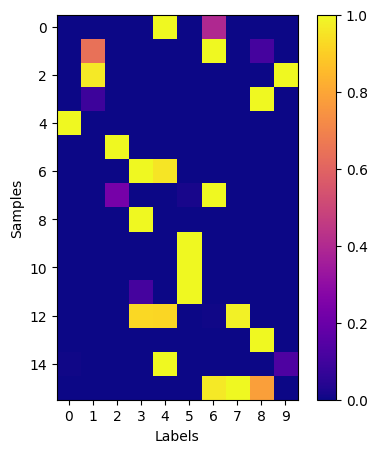

In [55]:
set_seed(42)
output = model(next(iter(train_loader))[0][:16].to(device))
plt.figure(figsize=(5,5))
plt.imshow(output.detach().cpu(), cmap="plasma", vmin=0., vmax=1.)
plt.xticks([i for i in range(output.shape[1])])
plt.xlabel("Labels")
plt.ylabel("Samples")
plt.colorbar()
plt.show()

* The plot above shows that the final layer of our trained model shows the level of "certainty" over a predicted label. Some are a clear choice, but some others cast some doubt.

---

Some considerations:

* ``model.train`` and ``model.eval`` control some underlying behaviours of the model that require different behaviours during training and inference time. For instance, ``batch normalisation`` layers no longer are activated for batch-statistics and ``dropout`` layers are deactivated (more on theses concepts in the upcoming lectures)

* ``torch.no_grad`` disables any gradient computation in ``torch.Tensors`` temporarily. Practically, this means more efficiency in inference since the computational graph of operations does not have to be retained.

* ``.detach()`` returns a new tensor that is detached from the current computational graph (gradients can no longer be computed). This is particularly useful for processing the tensor with other libraries (e.g. numpy, scikit-learn, etc)

## Deeper into ``Datasets``

* So far we have handled well-formated datasets that align very well with the ``torch`` library

* But how can we handle datasets that we might find online, or develop ourselves, that require different formating structures?

* ``ImageFolder`` is one useful base class provided by ``torchvision`` that relies on the following folder structure:

```
root/class_x/xxx.png
root/class_x/xxy.png
root/class_x/[...]/xxz.png

root/class_y/123.png
root/class_y/nsdf3.png
root/class_y/[...]/asd932_.png

```

In [59]:
%%html
<iframe src="https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html" width="600" height="700"></iframe>

* We will use a new dataset that is available on the [Kaggle](http://www.kaggle.com) platform

* To run the following code you will need a Kaggle account and an authentication ``json`` file

* To do so follow the 'Authentication' instructions on this link https://www.kaggle.com/docs/api

* Once you downloaded the ``kaggle.json`` file, upload it to ``MyDrive``

* You can use the snippet below to retrieve datasets from Kaggle in other projects as well

In [60]:
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle

!kaggle datasets download -d gpiosenka/butterfly-images40-species
!mkdir ./butterfly-images40-species
!unzip -q butterfly-images40-species.zip -d ./butterfly-images40-species

mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 399M/399M [00:21<00:00, 22.5MB/s]
100% 399M/399M [00:21<00:00, 19.3MB/s]
mkdir: cannot create directory ‘./butterfly-images40-species’: File exists


Dataset ImageFolder
    Number of datapoints: 12594
    Root location: ./butterfly-images40-species/train 

{'ADONIS': 0, 'AFRICAN GIANT SWALLOWTAIL': 1, 'AMERICAN SNOOT': 2, 'AN 88': 3, 'APPOLLO': 4, 'ARCIGERA FLOWER MOTH': 5, 'ATALA': 6, 'ATLAS MOTH': 7, 'BANDED ORANGE HELICONIAN': 8, 'BANDED PEACOCK': 9, 'BANDED TIGER MOTH': 10, 'BECKERS WHITE': 11, 'BIRD CHERRY ERMINE MOTH': 12, 'BLACK HAIRSTREAK': 13, 'BLUE MORPHO': 14, 'BLUE SPOTTED CROW': 15, 'BROOKES BIRDWING': 16, 'BROWN ARGUS': 17, 'BROWN SIPROETA': 18, 'CABBAGE WHITE': 19, 'CAIRNS BIRDWING': 20, 'CHALK HILL BLUE': 21, 'CHECQUERED SKIPPER': 22, 'CHESTNUT': 23, 'CINNABAR MOTH': 24, 'CLEARWING MOTH': 25, 'CLEOPATRA': 26, 'CLODIUS PARNASSIAN': 27, 'CLOUDED SULPHUR': 28, 'COMET MOTH': 29, 'COMMON BANDED AWL': 30, 'COMMON WOOD-NYMPH': 31, 'COPPER TAIL': 32, 'CRECENT': 33, 'CRIMSON PATCH': 34, 'DANAID EGGFLY': 35, 'EASTERN COMA': 36, 'EASTERN DAPPLE WHITE': 37, 'EASTERN PINE ELFIN': 38, 'ELBOWED PIERROT': 39, 'EMPEROR GUM MOTH': 40

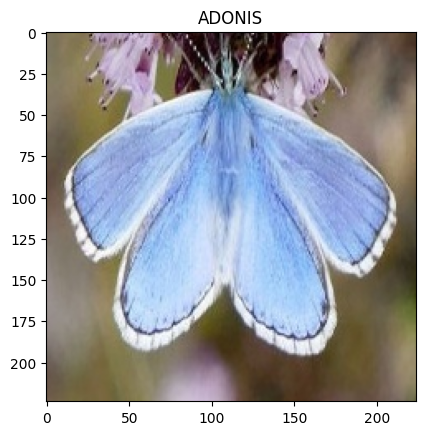

In [61]:
from torchvision.datasets import ImageFolder

butterfly_train_dataset = ImageFolder("./butterfly-images40-species/train")

print(butterfly_train_dataset, "\n")
print(butterfly_train_dataset.class_to_idx)

butterfly, target = butterfly_train_dataset[42]
plt.imshow(butterfly)
plt.title(list(butterfly_train_dataset.class_to_idx)[target])
plt.show()

* But we can also create our own dataset class to adapt to any data structure that we'd like.

* We can do so by taking advantage of the ``Dataset`` class in ``PyTorch``, which can be used as an base class for custom datasets

* From the documentation:

```
torch.utils.data.Dataset is an abstract class representing a dataset. Your custom dataset should inherit Dataset and override the following methods:

__len__ so that len(dataset) returns the size of the dataset.

__getitem__ to support the indexing such that dataset[i] can be used to get iith sample.

```

* Both methods are used by the ``Dataloader`` to sample the dataset. ``__getitem__`` returns a sample, and ``__len__`` defines the range in which ``__getitem__`` can be called.

---

* Let's now consider the same buttfly dataset, but instead of a classifiction problem, we are interested in a reconstruction one: deblurring.

* We design our problem such that our input is a blurred version of our target.

In [66]:
from torch.utils.data import Dataset
import os, glob
from PIL import Image
from torchvision.transforms import GaussianBlur

class BlurredButterflyDataset(Dataset):
    def __init__(self, root, kernel_size, sigma=(0.1, 2.0), transform=None):
        self.transform = transform
        self.root = root
        self.kernel_size = kernel_size
        self.sigma = sigma
        self.data_paths = self._get_image_paths()

    def _get_image_paths(self, exts=(".jpeg", ".jpg", ".png")):
        data_paths = []
        for root, dirs, files in os.walk(self.root):
            for file in files:
                if(file.endswith(exts)):
                    data_paths.append(os.path.join(root,file))
        return data_paths

    def __getitem__(self, idx):
        # Load image
        img_path = self.data_paths[idx]
        img = Image.open(img_path).convert("RGB")

        # Let's make to Tensor compulsory so we can manipulate the image as a tensor inside __getitem_
        img = ToTensor()(img)

        # Apply other transforms
        if self.transform:
            img = self.transform(img)

        # Blurred image
        blurred_img = GaussianBlur(kernel_size=self.kernel_size, sigma=self.sigma)(img)

        return blurred_img, img

    def __len__(self):
        return len(self.data_paths)

    def __str__(self):
        class_string = ""
        class_string += self.__class__.__name__
        class_string+="\n\tlen : %d"%self.__len__()
        for key, value in self.__dict__.items():
            if key != "data_paths":
                class_string+="\n\t" + str(key) + " : " + str(value)
        return class_string

BlurredButterflyDataset
	len : 12594
	transform : None
	root : ./butterfly-images40-species/train/
	kernel_size : (5, 5)
	sigma : (2.0, 2.0)


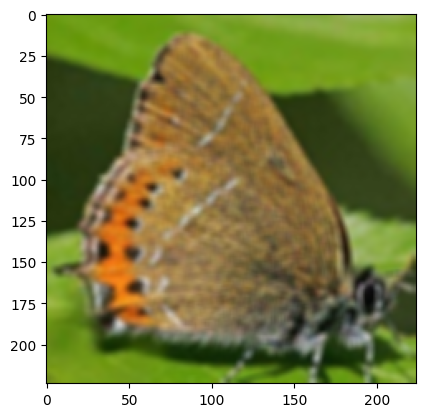

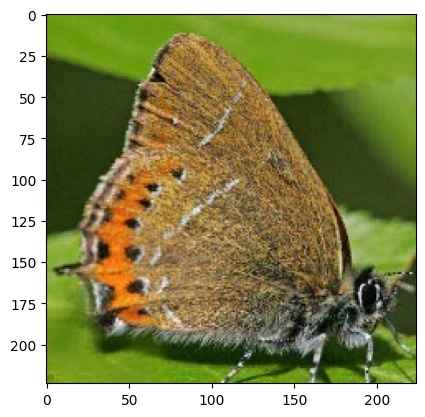

In [67]:
butterfly_train_dataset = BlurredButterflyDataset(root="./butterfly-images40-species/train/", kernel_size=(5,5), sigma=(2., 2.))
print(butterfly_train_dataset)
input, target = butterfly_train_dataset[0]
plt.imshow(input.permute(1,2,0))
plt.show()

plt.imshow(target.permute(1,2,0))
plt.show()

## Further considerations

* The options for customisation in ``Pytorch`` library are extensive. Mostly, you will **not** need to fully understand these concepts for a successful completion of this course.

* The documentation of ``Pytorch`` is full of examples, tutorials and paper references and will be your best reference to learn new application concepts and how to implement them.

* A few other considerations before we wrap up:

Mathematical Utils in ``Pytorch``

---
[``torch.linalg``](https://pytorch.org/docs/stable/linalg.html)
    - [``torch.fft``](https://pytorch.org/docs/stable/fft.html)
    - [``torch.random``](https://pytorch.org/docs/stable/random.html)
    - [``torch.sparse``](https://pytorch.org/docs/stable/sparse.html)
    - ...


Losses and Activations

---

The loss function drives the optimisation of machine learning models. It tells the model what it is meant to learn. In this sense, different tasks require different loss functions. In our examples so far, we have used ``CrossEntropy`` as our loss, which is well suited to multi-taks classification problems. In contrast, this loss function would not be suited, for example, to reconstruction problems. In this case we would require a loss function that would compare an image output to a target output. The ``MSELoss`` would be more suitable for this scenario. A wide range of loss functions are provided by ``Pytorch``, but it is up to you to decide which is more appropriate to your problem.






In [62]:
%%html
<iframe src="https://pytorch.org/docs/stable/nn.html#loss-functions" width="700" height="500"></iframe>


Learning Rate Annealing

---

Learning rate annealing refers to decreasing the learning rate during the course of optimisation. This has been shown to help with convergence and stabilisation of your model, while also cutting training time. In ``Pytorch`` the implementation of learning rate annealing follows a similar syntax to the implementation of the optimiser, with different annealing strategies offered.


In [63]:
%%html
<iframe src="https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate" width="700" height="500"></iframe>


Dataloader sampler

---

As with custom ``Dataset`` classes, we can also design better sampling strategies that are better suited to our dataset. This is an interesting way of adding or removing biases in our model. For instance, using a standard sampler for a dataset that has different amounts of data per class will bias our model to perform better to the classes that contain more samples. We can instead use a ``WeightedSampler`` to increase the probability of a weaker class to show up in our batches. As per usual, ``Pytorch`` offers a wide range of sampling strategies that can be passed into the ``Dataloader``, including a base ``Sampler`` class so we can customise our own.


In [64]:
%%html

<iframe src="https://pytorch.org/docs/stable/data.html#torch.utils.data.Sampler" width="700" height="500"></iframe>


Model Initialisations

---

The initialisation of weights in our model can have significant impact on its convergence and performance. It is natural that ``Pytorch`` will also offer different ways to initialise the model weights. For most layers, the default initialisation method is the ``Kaiming Uniform``, which is described in the documentation:




In [65]:
%%html
<iframe src="https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_uniform_" width="700" height="500"></iframe>